# RAKE para extracción de palabras clave

El método para extracción de palabras clave es RAKE (Rapid Automatic Keyword Extraction) que se basa en los siguientes supuestos:

* Los términos se componen de diferentes palabras.
* No contienen signos de puntación ni otros elementos ortográficos.
* Los candidatos a términos serán aquellos que se relacionen mayormente con otros términos.
* Los candidatos a términos no serán los términos más frecuentes; son inversamente proporcionales a su frecuencia.

Aquí implementamos RAKE para un corpus enfocándonos en una sóla categoría.

In [1]:
from nltk.corpus import brown, stopwords
from nltk.stem import SnowballStemmer
from collections import defaultdict, Counter
from itertools import chain, combinations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Utilizaremos una lista de paro así como un stemmer para pre-procesar el corpus. Definimos una función de normalización que elimina stopwords, pasa a minúsculas y stemmiza.

In [2]:
#Stopwords
paro = stopwords.words('english')
#Stemmer
stemmer = SnowballStemmer('english')
#Función de normalización/pre-procesamiento
normalize = lambda sent: [stemmer.stem(w.lower()) for w in sent if w.isalpha()==True]

El siguiente paso es obtener el vocabulario, para esto tokenizamos y pre-procesamos. Asimismo, obtenemos las frecuencias de los tokens y los indexamos.

In [3]:
#Normaliza cada oración del corpus
sentences = [normalize(sent) for sent in brown.sents(categories=['religion'])]
#Obtenemos la lista de tokens
tokens = list(chain(*sentences))
#Contamos la frecuencia de tokens
freq = Counter(tokens)
#Indexamos los tokens
index = {token:idx for idx,token in enumerate(freq.keys())}

Podemos ver el comportamiento de los términos con respecto a sus frecuencias.

In [4]:
#Términos en dataframe
terms = pd.DataFrame(data=freq.values(), index=list(freq.keys()),
                         columns=['Frequency'])
terms.sort_values(by='Frequency', ascending=False)

,Frequency
the,2480
of,1505
and,962
to,904
in,774
...,...
moscow,1
chanc,1
nervous,1
reckless,1


#### Creación de la gráfica de relaciones

Para crear la gráfica llenamos la matriz de adyacencia. Sumamos 1 cada vez que encontramos que dos términos coinciden dentro de una oración. Al final, los términos que más coocurren tendrán conexiones más fueretes.

In [5]:
#Matriz de adyacencia
A = np.zeros((len(index),len(index)))
for sent in sentences:
    #Llenamos con las coocurrencias de los pares términos
    for term1, term2 in combinations(sent,2):
        A[index[term1],index[term2]] += 1
        A[index[term2],index[term1]] += 1

Podemos vizualizar la matriz de adyacencia para ver cuáles son los términos que más coocurren.

In [6]:
Adj = pd.DataFrame(data=A, index=list(index.keys()), columns=list(index.keys()))
Adj

,as,a,result,although,we,still,make,use,of,this,...,shout,rotogravur,thump,whir,medium,sat,desk,crucifix,ivori,velvet
as,200.0,167.0,8.0,6.0,54.0,10.0,8.0,12.0,441.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a,167.0,444.0,6.0,15.0,83.0,25.0,14.0,23.0,906.0,117.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
result,8.0,6.0,0.0,1.0,2.0,1.0,1.0,2.0,17.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
although,6.0,15.0,1.0,0.0,4.0,4.0,1.0,1.0,21.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
we,54.0,83.0,2.0,4.0,120.0,5.0,10.0,8.0,246.0,58.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
desk,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
crucifix,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
ivori,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


A partir de la matriz de adyacencia obtenemos la matriz de grado como:

$$D = d_{i,i} = \sum_j a_{i,j}$$

Finalmente podemos calcular el índice Rake como:

$$RAKE(w_i) = \frac{deg(w_i)}{f_i}$$

In [7]:
#Matriz de grado
D = Adj.sum()
#Valores de Rake
scores = D/terms['Frequency']

Podemos ver cómo se comporta el índice RAKE con respecto a la frecuencia.

In [8]:
#Agregamos índice RAKE a dataframe
terms['RAKE'] = scores

terms.sort_values(by='RAKE', ascending=False)

,Frequency,RAKE
destin,1,76.0
appetit,1,76.0
penalti,1,76.0
lift,1,71.0
refut,1,71.0
...,...,...
jude,1,0.0
galatian,2,0.0
colossian,1,0.0
c,1,0.0


Asimismo, podemos visualizar la nube de palabras con respecto al índice RAKE.

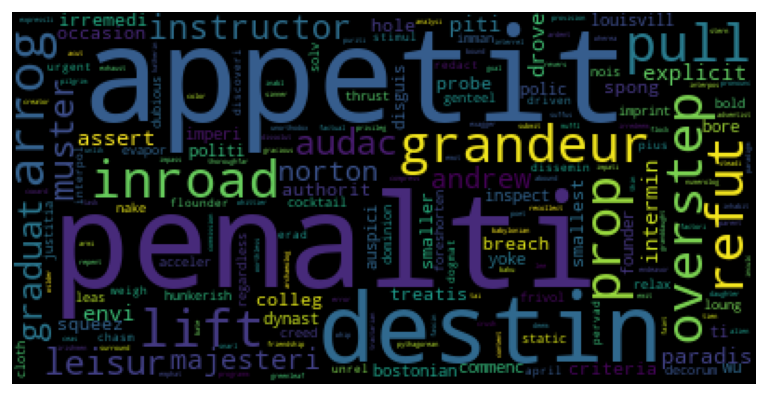

In [9]:
mycloud = WordCloud()

mycloud.generate_from_frequencies(scores)

plt.figure(figsize=(8,6), dpi=120)
plt.imshow(mycloud)
plt.axis("off")
plt.show()